## Importing Libraries and Loading Data

In [1]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

## Data Exploration

In [2]:
df_weekly = nfl.import_weekly_data([2021, 2022, 2023])
df_weekly = df_weekly[df_weekly['season_type']=='REG']
df_weekly = df_weekly[df_weekly['position']=='QB']
df_weekly.info()

Downcasting floats.
<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 5636
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    1994 non-null   object 
 1   player_name                  1994 non-null   object 
 2   player_display_name          1994 non-null   object 
 3   position                     1994 non-null   object 
 4   position_group               1994 non-null   object 
 5   headshot_url                 1994 non-null   object 
 6   recent_team                  1994 non-null   object 
 7   season                       1994 non-null   int32  
 8   week                         1994 non-null   int32  
 9   season_type                  1994 non-null   object 
 10  opponent_team                1994 non-null   object 
 11  completions                  1994 non-null   int32  
 12  attempts                     1994 non-null   int32  
 13  pas

In [3]:
df_weekly.isnull().sum()

player_id                         0
player_name                       0
player_display_name               0
position                          0
position_group                    0
headshot_url                      0
recent_team                       0
season                            0
week                              0
season_type                       0
opponent_team                     0
completions                       0
attempts                          0
passing_yards                     0
passing_tds                       0
interceptions                     0
sacks                             0
sack_yards                        0
sack_fumbles                      0
sack_fumbles_lost                 0
passing_air_yards                 0
passing_yards_after_catch         0
passing_first_downs               0
passing_epa                      95
passing_2pt_conversions           0
pacr                            104
dakota                          245
carries                     

In [4]:
df_weekly.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,27.160000,27.160000
1,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,2,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,29.639999,29.639999
2,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,3,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,28.680000,28.680000
3,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,4,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,11.060000,11.060000
4,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,5,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,37.740002,37.740002


In [5]:
df_weekly.columns

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [6]:
columns_to_drop = ['headshot_url', 'season_type', 'sack_yards',
        'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
        'passing_yards_after_catch', 'passing_first_downs',
        'passing_epa', 'pacr', 'dakota', 'sacks', 
        'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
        'receiving_fumbles_lost', 'receiving_yards_after_catch',
        'receiving_first_downs', 'receiving_epa', 'racr',
        'target_share', 'air_yards_share', 'wopr',
        'special_teams_tds', 'player_display_name',
        'receiving_air_yards', 'player_name', 
        'position_group', 'fantasy_points', 'fantasy_points_ppr']

In [7]:
df_weekly = df_weekly.drop(columns=columns_to_drop)

In [8]:
df_weekly['player_id'] = df_weekly['player_id'].str.replace('00-', '').astype(int)

In [9]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 5636
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  1994 non-null   int64  
 1   position                   1994 non-null   object 
 2   recent_team                1994 non-null   object 
 3   season                     1994 non-null   int32  
 4   week                       1994 non-null   int32  
 5   opponent_team              1994 non-null   object 
 6   completions                1994 non-null   int32  
 7   attempts                   1994 non-null   int32  
 8   passing_yards              1994 non-null   float32
 9   passing_tds                1994 non-null   int32  
 10  interceptions              1994 non-null   float32
 11  passing_2pt_conversions    1994 non-null   int32  
 12  carries                    1994 non-null   int32  
 13  rushing_yards              1994 non-null   float32
 1

In [10]:
df_weekly.isnull().sum()

player_id                    0
position                     0
recent_team                  0
season                       0
week                         0
opponent_team                0
completions                  0
attempts                     0
passing_yards                0
passing_tds                  0
interceptions                0
passing_2pt_conversions      0
carries                      0
rushing_yards                0
rushing_tds                  0
rushing_fumbles              0
rushing_2pt_conversions      0
receptions                   0
targets                      0
receiving_yards              0
receiving_tds                0
receiving_fumbles            0
receiving_2pt_conversions    0
dtype: int64

## Feature Selection

In [11]:
X = df_weekly.drop(columns=['passing_yards', 'passing_tds', 
                            'passing_2pt_conversions', 
                            'rushing_yards', 
                            'rushing_tds', 
                            'rushing_2pt_conversions', 
                            'receiving_yards', 
                            'receiving_tds', 
                            'receiving_2pt_conversions', 
                            'attempts', 'completions', 'carries',
                            'targets', 'receptions',
                            'rushing_fumbles',
                            'receiving_fumbles',
                            'interceptions', 'position'])
X

,player_id,recent_team,season,week,opponent_team
0,19596,TB,2021,1,DAL
1,19596,TB,2021,2,ATL
2,19596,TB,2021,3,LA
3,19596,TB,2021,4,NE
4,19596,TB,2021,5,MIA
...,...,...,...,...,...
5630,39163,HOU,2023,18,IND
5633,39164,IND,2023,1,JAX
5634,39164,IND,2023,2,HOU
5635,39164,IND,2023,4,LA


In [12]:
# y = df_weekly[['passing_yards', 'passing_tds', 'passing_2pt_conversions', 
#               'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 
#               'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 
#                'attempts', 'completions', 'carries', 'targets',
#                'receptions', 'rushing_fumbles', 'receiving_fumbles',
#                'interceptions']]

y =df_weekly['passing_yards']

           player_id    season      week
player_id   1.000000  0.264617  0.024177
season      0.264617  1.000000  0.007488
week        0.024177  0.007488  1.000000


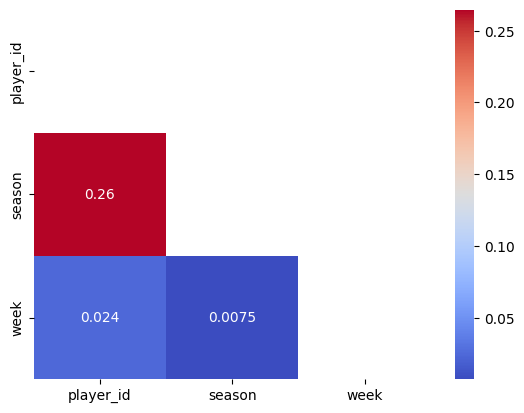

In [13]:
corr = X.select_dtypes('number').corr()
print(corr)
sns.heatmap(corr, annot=True, mask=np.triu(corr), cmap='coolwarm')
plt.show()

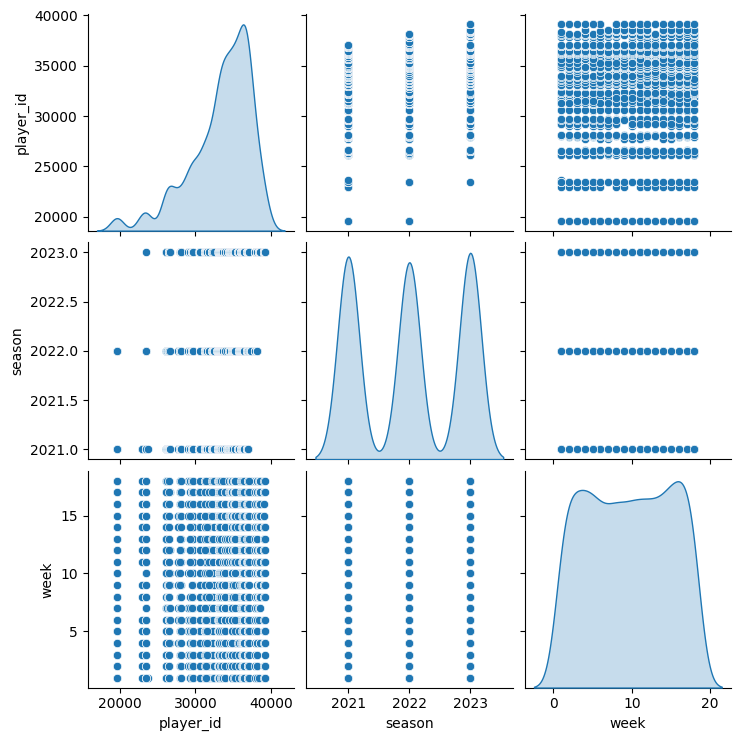

In [14]:
sns.pairplot(X, diag_kind='kde')

## Data Splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1595 entries, 104 to 3583
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   player_id      1595 non-null   int64 
 1   recent_team    1595 non-null   object
 2   season         1595 non-null   int32 
 3   week           1595 non-null   int32 
 4   opponent_team  1595 non-null   object
dtypes: int32(2), int64(1), object(2)
memory usage: 62.3+ KB


In [16]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 1042 to 914
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   player_id      399 non-null    int64 
 1   recent_team    399 non-null    object
 2   season         399 non-null    int32 
 3   week           399 non-null    int32 
 4   opponent_team  399 non-null    object
dtypes: int32(2), int64(1), object(2)
memory usage: 15.6+ KB


In [17]:
type(X_train)
X_train

,player_id,recent_team,season,week,opponent_team
104,29701,TEN,2023,2,LAC
3862,37013,NYJ,2023,4,KC
11,19596,TB,2022,13,NO
2896,35228,ARI,2022,5,PHI
1436,33949,ARI,2023,8,BAL
...,...,...,...,...,...
3587,36212,MIA,2022,8,DET
5525,38102,PIT,2022,12,IND
736,31800,WAS,2022,13,NYG
817,33077,DAL,2023,12,WAS


## Extreme Gradient Boosting

### Pipeline

In [18]:
numeric_features = ['player_id', 'season', 'week']
categorical_features = list(set(X.columns) - set(numeric_features))
categorical_features

['recent_team', 'opponent_team']

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="median"), numeric_features),
    ("cat", OneHotEncoder(drop = 'first', sparse_output=False), categorical_features),    
])



In [20]:
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor())
])

In [ ]:
X_train.head()

In [21]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['player_id', 'season',
                                                   'week']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['recent_team',
                                                   'opponent_team'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_byt...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [22]:
xgb['model'].get_booster().feature_names = numeric_features + categorical_features

In [23]:
xgb.score(X_test, y_test)

0.24491703510284424

## Interpretability (SHAP Explainer)

In [28]:
# init a tree explainer to explain the xgb model
explainer = shap.TreeExplainer(xgb['model'], feature_names=xgb['model'].feature_names_in_)
# use the explainer to explain the Model based on the Train data
xgb_explanation = explainer(xgb['preprocessor'].transform(X_train))

In [29]:
xgb['preprocessor'].get_feature_names_out()

array(['num__player_id', 'num__season', 'num__week',
       'cat__recent_team_ATL', 'cat__recent_team_BAL',
       'cat__recent_team_BUF', 'cat__recent_team_CAR',
       'cat__recent_team_CHI', 'cat__recent_team_CIN',
       'cat__recent_team_CLE', 'cat__recent_team_DAL',
       'cat__recent_team_DEN', 'cat__recent_team_DET',
       'cat__recent_team_GB', 'cat__recent_team_HOU',
       'cat__recent_team_IND', 'cat__recent_team_JAX',
       'cat__recent_team_KC', 'cat__recent_team_LA',
       'cat__recent_team_LAC', 'cat__recent_team_LV',
       'cat__recent_team_MIA', 'cat__recent_team_MIN',
       'cat__recent_team_NE', 'cat__recent_team_NO',
       'cat__recent_team_NYG', 'cat__recent_team_NYJ',
       'cat__recent_team_PHI', 'cat__recent_team_PIT',
       'cat__recent_team_SEA', 'cat__recent_team_SF',
       'cat__recent_team_TB', 'cat__recent_team_TEN',
       'cat__recent_team_WAS', 'cat__opponent_team_ATL',
       'cat__opponent_team_BAL', 'cat__opponent_team_BUF',
       'cat__o

In [30]:
xgb_explanation.values

array([[ 35.402645  ,   8.200633  ,  18.854353  , ...,  -0.3644165 ,
         -1.4473692 ,  -0.72618246],
       [-14.043314  ,  -2.3838313 ,  23.942757  , ...,  -1.0220271 ,
         -1.3885365 ,  -1.2708076 ],
       [ 87.41938   , -11.056719  ,   4.3032203 , ...,  -0.53313535,
         -0.6125634 ,   0.52411425],
       ...,
       [  1.8546143 ,   1.6834266 , -17.063877  , ...,  -0.47991952,
         -1.2469221 ,  -0.27107552],
       [ 69.7089    ,  -0.14417802,   9.136104  , ...,  -0.5527613 ,
         -0.76147217,  12.999536  ],
       [ 64.42815   ,   1.3786594 ,  49.63065   , ...,  -0.6223255 ,
         -0.79776764,  -1.0672724 ]], dtype=float32)

In [33]:
X_train.columns

Index(['player_id', 'recent_team', 'season', 'week', 'opponent_team'], dtype='object')

In [35]:
shap_df = pd.DataFrame(xgb_explanation.values, columns = xgb['preprocessor'].get_feature_names_out())
shap_df.head()

,num__player_id,num__season,num__week,cat__recent_team_ATL,cat__recent_team_BAL,cat__recent_team_BUF,cat__recent_team_CAR,cat__recent_team_CHI,cat__recent_team_CIN,cat__recent_team_CLE,...,cat__opponent_team_NO,cat__opponent_team_NYG,cat__opponent_team_NYJ,cat__opponent_team_PHI,cat__opponent_team_PIT,cat__opponent_team_SEA,cat__opponent_team_SF,cat__opponent_team_TB,cat__opponent_team_TEN,cat__opponent_team_WAS
0,35.402645,8.200633,18.854353,-0.078760,0.039145,0.822142,-0.005833,2.143606,0.234847,-0.357674,...,0.370060,-0.027892,0.459727,0.277302,-0.842284,-1.553038,-0.032011,-0.364417,-1.447369,-0.726182
1,-14.043314,-2.383831,23.942757,-0.091694,0.025999,-0.818560,-0.053317,0.811726,-0.853863,-0.213682,...,-0.356498,0.264101,0.791492,-0.492164,-1.511185,-0.432942,0.202711,-1.022027,-1.388536,-1.270808
2,87.419380,-11.056719,4.303220,-1.284304,0.130947,0.872603,0.313557,0.444319,0.169283,-0.665444,...,-10.023314,0.601246,-0.289467,0.527301,0.581710,0.249475,-0.100802,-0.533135,-0.612563,0.524114
3,37.852772,-2.528761,10.780245,-0.062791,0.024353,-1.055179,0.102764,0.901406,-0.999722,-0.215655,...,1.238349,1.024512,0.259087,-1.791382,-0.045980,-0.471097,-0.159808,-0.640239,-0.799145,-0.884849
4,-46.220600,-3.197504,28.991138,-0.034883,0.057144,0.556375,0.230013,1.321986,-0.789087,-0.227019,...,0.386199,0.732408,0.491141,-0.446651,-1.122886,-0.409853,-0.307714,-0.712236,-0.536261,-0.718205


### Global Explanation

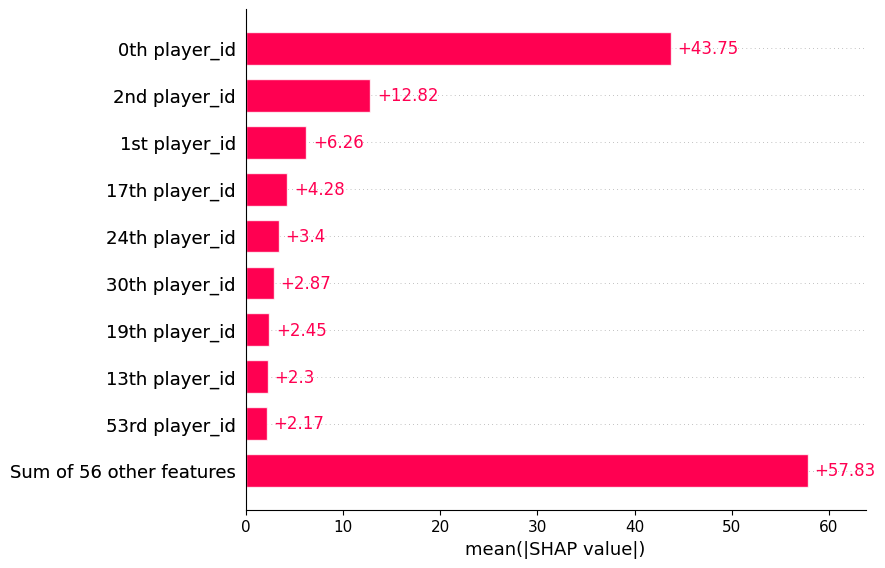

In [38]:
# SHAP Feature Importance
shap.plots.bar(xgb_explanation)

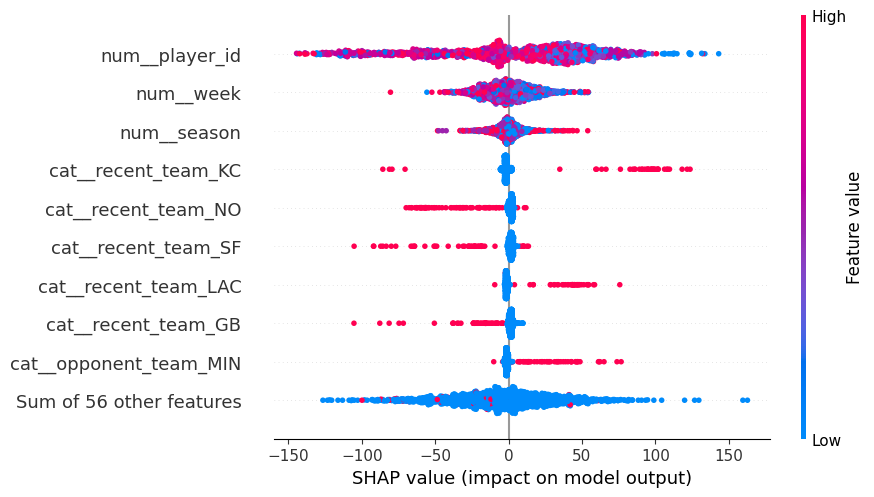

In [46]:
# Beeswarm
feature_names = xgb['preprocessor'].get_feature_names_out()
xgb_explanation.feature_names = feature_names
shap.plots.beeswarm(xgb_explanation)

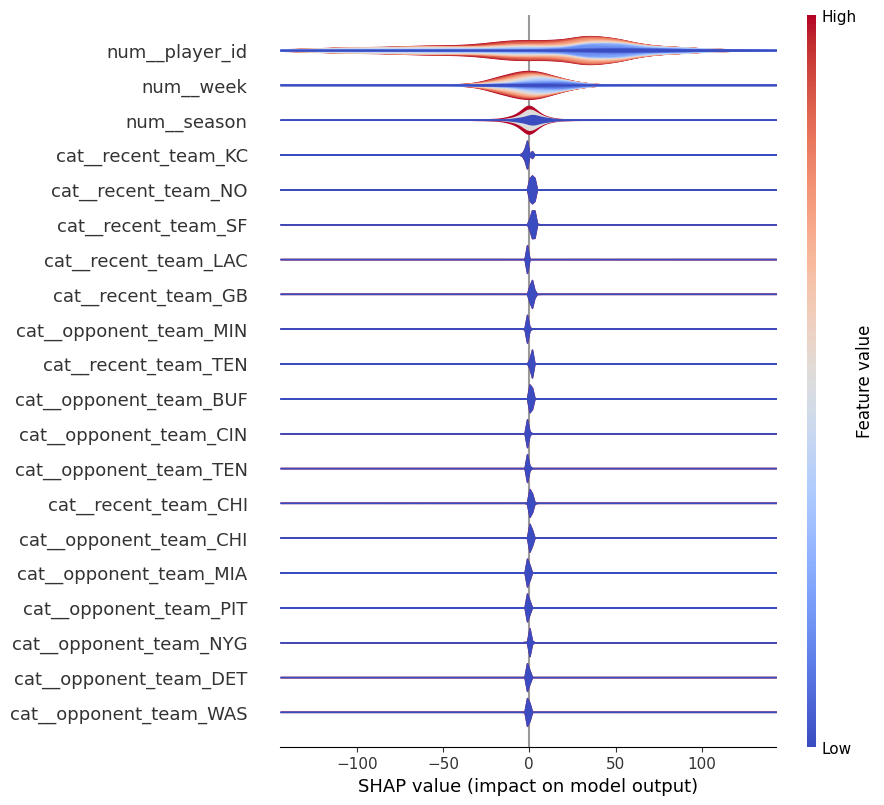

In [47]:
# Violin
shap.plots.violin(xgb_explanation, plot_type="layered_violin")